In [1]:
import pandas as pd
import pandas_datareader.data as web
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from datetime import datetime, timedelta, time
import yfinance as yf
import seaborn as sns
import statsmodels.api as sm

In [2]:
spx_data = pd.read_parquet("data/spxoptions.parquet")
vix_data = pd.read_parquet("data/vixoptions.parquet")
start_date, end_date = "2010-01-01", "2023-12-31"
rf_data = yf.download(
    "^IRX", start=start_date, end=end_date, auto_adjust=True
)  # in percent points
vx_data = pd.read_parquet("data/vix_futures.parquet")
spx_underlying = yf.download("^GSPC", start=start_date, end=end_date, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
processed_data = []
for date, group in vx_data.groupby(vx_data.index):
    sorted_group = group.sort_values(by="expiry")
    row_data = {"date": date}
    if (
        date == sorted_group.iloc[0]["expiry"]
    ):  # to avoid contracts expiring today, which will be hard to trade anyways, this also avoids some problems with vix options since they expire on the tuesday before the final trading day
        sorted_group = sorted_group.iloc[1:]
        for i, (_, contract) in enumerate(sorted_group.head(2).iterrows(), start=1):
            for column in contract.index:
                if column != "csi_symbol":
                    row_data[f"vx{i}{column}"] = contract[column]
    else:
        for i, (_, contract) in enumerate(sorted_group.head(3).iterrows(), start=1):
            for column in contract.index:
                if column != "csi_symbol":
                    row_data[f"vx{i}{column}"] = contract[column]

    processed_data.append(row_data)

vx = pd.DataFrame(processed_data)
vx.set_index("date", inplace=True)
vx = vx[(vx.index >= start_date) & (vx.index <= end_date)]
vx = vx.join(spx_underlying.Close["^GSPC"].rename("SPX_Close"))
vx.index = vx.index.date

rf = rf_data.Close["^IRX"]
rf.index = rf.index.date

In [4]:
# spot spx = ' [UNDERLYING_LAST]'
# output df: efg1, efg2 for each day
spx_data[" [QUOTE_DATE]"] = pd.to_datetime(spx_data[" [QUOTE_DATE]"]).dt.date
spx_data[" [EXPIRE_DATE]"] = pd.to_datetime(spx_data[" [EXPIRE_DATE]"]).dt.date
spx_data[
    [" [UNDERLYING_LAST]", " [C_BID]", " [C_ASK]", " [STRIKE]", " [P_BID]", " [P_ASK]"]
] = spx_data[
    [" [UNDERLYING_LAST]", " [C_BID]", " [C_ASK]", " [STRIKE]", " [P_BID]", " [P_ASK]"]
].apply(
    pd.to_numeric, errors="coerce"
)
spx_data_grouped = spx_data.groupby(" [QUOTE_DATE]")
vix_data[" [QUOTE_DATE]"] = pd.to_datetime(vix_data[" [QUOTE_DATE]"]).dt.date
vix_data[" [EXPIRE_DATE]"] = pd.to_datetime(vix_data[" [EXPIRE_DATE]"]).dt.date
vix_data_grouped = vix_data.groupby(" [QUOTE_DATE]")
vx["vx1expiry"] = pd.to_datetime(vx["vx1expiry"]).dt.date
vx["vx2expiry"] = pd.to_datetime(vx["vx2expiry"]).dt.date

In [5]:
def calc_forward_iv(chain, dte, rfr, spot):  # need specifically the chain of the day
    T = dte / 365
    r = rfr / 100
    forward = spot * np.exp(r * T)
    chain = chain.copy()

    K0 = chain.loc[abs(chain[" [STRIKE]"] - forward).idxmin(), " [STRIKE]"]

    otmcalls = chain[chain[" [STRIKE]"] >= K0]
    otmputs = chain[chain[" [STRIKE]"] <= K0]
    call_bound = otmcalls[
        ((otmcalls[" [C_BID]"] == 0) & (otmcalls.shift(-1)[" [C_BID]"] == 0))
        | ((otmcalls[" [C_ASK]"] == 0) & (otmcalls.shift(-1)[" [C_ASK]"] == 0))
        | (otmcalls[" [C_BID]"].isna())
        | (otmcalls[" [C_ASK]"].isna())
    ].index.min()
    put_bound = otmputs[
        ((otmputs[" [P_BID]"] == 0) & (otmputs.shift(1)[" [P_BID]"] == 0))
        | ((otmputs[" [P_ASK]"] == 0) & (otmputs.shift(1)[" [P_ASK]"] == 0))
        | (otmputs[" [P_BID]"].isna())
        | (otmputs[" [P_ASK]"].isna())
    ].index.max()

    if pd.notna(call_bound):
        chain = chain.loc[: call_bound - 1]  # right end is inclusive in pd loc
    if pd.notna(put_bound):
        chain = chain.loc[put_bound + 1 :]
    if otmcalls.empty or otmputs.empty:
        raise ValueError(
            f"no OTM options check code {chain.loc[:," [QUOTE_DATE]"].iloc[0]} exp {chain.loc[:," [EXPIRE_DATE]"].iloc[0]}"
        )

    chain = chain[
        ~(
            (
                (chain[" [STRIKE]"] >= K0)
                & ((chain[" [C_BID]"] == 0) | (chain[" [C_ASK]"] == 0))
            )
            | (
                (chain[" [STRIKE]"] <= K0)
                & ((chain[" [P_BID]"] == 0) | (chain[" [P_ASK]"] == 0))
            )
        )
    ]  # ignoring rows that have either 0 bid or ask

    chain["dK"] = (chain[" [STRIKE]"].shift(-1) - chain[" [STRIKE]"].shift(1)) / 2
    chain.loc[chain.index[0], "dK"] = (
        chain.loc[chain.index[1], " [STRIKE]"] - chain.loc[chain.index[0], " [STRIKE]"]
    )
    chain.loc[chain.index[-1], "dK"] = (
        chain.loc[chain.index[-1], " [STRIKE]"]
        - chain.loc[chain.index[-2], " [STRIKE]"]
    )
    otmcalls = chain[chain[" [STRIKE]"] >= K0]
    otmputs = chain[chain[" [STRIKE]"] <= K0]

    call_vals = (
        (
            otmcalls[otmcalls[" [STRIKE]"] != K0][" [C_BID]"]
            + otmcalls[otmcalls[" [STRIKE]"] != K0][" [C_ASK]"]
        )
        / 2
        * (
            otmcalls[otmcalls[" [STRIKE]"] != K0]["dK"]
            / otmcalls[otmcalls[" [STRIKE]"] != K0][" [STRIKE]"] ** 2
        )
    )
    put_vals = (
        (
            otmputs[otmputs[" [STRIKE]"] != K0][" [P_BID]"]
            + otmputs[otmputs[" [STRIKE]"] != K0][" [P_ASK]"]
        )
        / 2
        * (
            otmputs[otmputs[" [STRIKE]"] != K0]["dK"]
            / otmputs[otmputs[" [STRIKE]"] != K0][" [STRIKE]"] ** 2
        )
    )
    forwardiv = (
        2
        / T
        * np.exp(r * T)
        * (
            np.sum(call_vals)
            + interpolate(otmcalls, "call", "fiv")
            + np.sum(put_vals)
            + interpolate(otmputs, "put", "fiv")
            + (otmcalls.iloc[0][" [C_BID]"] + otmcalls.iloc[0][" [C_ASK]"])
            / 4
            * (otmcalls.iloc[0]["dK"] / otmcalls.iloc[0][" [STRIKE]"] ** 2)
            + (otmputs.iloc[-1][" [P_BID]"] + otmputs.iloc[-1][" [P_ASK]"])
            / 4
            * (otmputs.iloc[-1]["dK"] / otmputs.iloc[-1][" [STRIKE]"] ** 2)
        )
        - 1 / T * (forward / K0 - 1) ** 2
    )

    # debug line
    """
    if chain.loc[:, " [QUOTE_DATE]"].iloc[0] == pd.to_datetime('2015-10-20').date():
        print(chain.loc[:, " [EXPIRE_DATE]"].iloc[0])
        print(forward, K0, forwardiv)
        print(otmcalls.iloc[-1][" [STRIKE]"])
        print(otmputs.iloc[0][" [STRIKE]"])
        """
    return (
        10000 * forwardiv
    )  # 100^2, since varq is measured on vix options, therefore this also needs to be scaled to actual vix


def calc_varq(chain, dte, rfr, forward):
    # in varq the chain is the vix chain and spot is spot vix
    calls_bounded, puts_bounded = False, False
    T = dte / 365
    r = rfr / 100
    chain = chain.copy()
    chain["dK"] = (chain[" [STRIKE]"].shift(-1) - chain[" [STRIKE]"].shift(1)) / 2
    chain.loc[chain.index[0], "dK"] = (
        chain.loc[chain.index[1], " [STRIKE]"] - chain.loc[chain.index[0], " [STRIKE]"]
    )
    chain.loc[chain.index[-1], "dK"] = (
        chain.loc[chain.index[-1], " [STRIKE]"]
        - chain.loc[chain.index[-2], " [STRIKE]"]
    )
    K0 = chain.loc[abs(chain[" [STRIKE]"] - forward).idxmin(), " [STRIKE]"]
    otmcalls = chain[chain[" [STRIKE]"] >= K0]
    otmputs = chain[chain[" [STRIKE]"] <= K0]
    call_bound = otmcalls[
        (otmcalls[" [C_BID]"] == 0)
        | (otmcalls[" [C_ASK]"] == 0)
        | (otmcalls[" [C_BID]"].isna())
        | (otmcalls[" [C_ASK]"].isna())
    ].index.min()
    put_bound = otmputs[
        (otmputs[" [P_BID]"] == 0)
        | (otmputs[" [P_ASK]"] == 0)
        | (otmputs[" [P_BID]"].isna())
        | (otmputs[" [P_ASK]"].isna())
    ].index.max()
    if pd.notna(call_bound):
        otmcalls = otmcalls.loc[: call_bound - 1]
        calls_bounded = True
    if pd.notna(put_bound):
        otmputs = otmputs.loc[put_bound + 1 :]
        puts_bounded = True
    if calls_bounded == False:
        print(chain.loc[:," [QUOTE_DATE]"].iloc[0], chain.loc[:, " [EXPIRE_DATE]"].iloc[0], "vix calls unbounded")
    if puts_bounded == False:
        print(chain.loc[:," [QUOTE_DATE]"].iloc[0], chain.loc[:, " [EXPIRE_DATE]"].iloc[0], "vix puts unbounded")

    if otmcalls.empty and otmputs.empty:
        raise ValueError(
            f"no OTM options on VIX check code {chain.loc[:," [QUOTE_DATE]"].iloc[0]} exp {chain.loc[:," [EXPIRE_DATE]"].iloc[0]}"
        )
    elif otmputs.empty and not otmcalls.empty:
        # print(f"no OTM puts on VIX on {chain.loc[:,' [QUOTE_DATE]'].iloc[0]} exp {chain.loc[:,' [EXPIRE_DATE]'].iloc[0]}")
        call_vals = (otmcalls[" [C_BID]"] + otmcalls[" [C_ASK]"]) / 2 * otmcalls["dK"]
        varq = 2 * np.exp(r * T) * (np.sum(call_vals)+(interpolate(otmcalls, "call", "varq") if not calls_bounded else 0))
    elif otmcalls.empty and not otmputs.empty:
        put_vals = (otmputs[" [P_BID]"] + otmputs[" [P_ASK]"]) / 2 * otmputs["dK"]
        varq = 2 * np.exp(r * T) * (np.sum(put_vals)+(interpolate(otmputs, "put", "varq") if not puts_bounded else 0))
    else:
        call_vals = (
            (
                otmcalls[otmcalls[" [STRIKE]"] != K0][" [C_BID]"]
                + otmcalls[otmcalls[" [STRIKE]"] != K0][" [C_ASK]"]
            )
            / 2
            * otmcalls[otmcalls[" [STRIKE]"] != K0]["dK"]
        )
        put_vals = (
            (
                otmputs[otmputs[" [STRIKE]"] != K0][" [P_BID]"]
                + otmputs[otmputs[" [STRIKE]"] != K0][" [P_ASK]"]
            )
            / 2
            * otmputs[otmputs[" [STRIKE]"] != K0]["dK"]
        )
        varq = (
            2
            * np.exp(r * T)
            * (
                np.sum(call_vals)
                + np.sum(put_vals)
                +(interpolate(otmcalls, "call", "varq") if not calls_bounded else 0)
                +(interpolate(otmputs, "put", "varq") if not puts_bounded else 0)
                + (otmcalls.iloc[0][" [C_BID]"] + otmcalls.iloc[0][" [C_ASK]"])
                / 4
                * otmcalls.iloc[0]["dK"]
                + (otmputs.iloc[-1][" [P_BID]"] + otmputs.iloc[-1][" [P_ASK]"])
                / 4
                * otmputs.iloc[-1]["dK"]
            )
        )
    return varq

#TODO: change type based on varq or eq
def interpolate(chain, type, component):
    # sometimes, the chain gets "cut off" because there are not enough strikes. this results in an incorrect calculation of the implied vix future value
    # there are no easy workarounds. here are the few things we can do:
    # 1. ignore expiry if we cannot find call_bound or put_bound. however sometimes we cannot simply skip an expiry day (sometimes we do not have the luxury of finding another expiry day that works for our vx expiry)
    # 2. choosing only monthlies, but this is considerably less accurate, and in older years sometimes even monthlies do not have reliable strikes
    # 3. interpolating otm option prices, but this introduces errors due to assumptions being used in the distribution of prices. however, this is the most reasonable approach as of now
    # this interpolation function will attempt to estimate the size of the tail that is "cut off" from the option chain, and return 0 if the tail is not cut off (ie bound exists)

    # print(f'interpolating {chain.loc[:," [QUOTE_DATE]"].iloc[0]} exp {chain.loc[:," [EXPIRE_DATE]"].iloc[0]}')
    if len(chain) == 0:
        raise ValueError(
            f"interpolating null chain {chain.loc[:," [QUOTE_DATE]"].iloc[0]} exp {chain.loc[:," [EXPIRE_DATE]"].iloc[0]}"
        )
    elif len(chain) == 1:
        print(
            f"unable to interpolate chain with 1 data point {chain.loc[:,' [QUOTE_DATE]'].iloc[0]} exp {chain.loc[:,' [EXPIRE_DATE]'].iloc[0]}"
        )
        return 0
    else:
        if type == "call":
            cutoff = chain.iloc[-1]
            cutoffminus1 = chain.iloc[-2]
            c1 = cutoff[" [STRIKE]"]
            f1 = (cutoff[" [C_BID]"] + cutoff[" [C_ASK]"]) / 2
            x = cutoff[" [STRIKE]"] - cutoffminus1[" [STRIKE]"]
            y = (cutoff[" [C_BID]"] + cutoff[" [C_ASK]"]) / 2 - (
                cutoffminus1[" [C_BID]"] + cutoffminus1[" [C_ASK]"]
            ) / 2
            if round(y, 3) >= 0:
                f1 = (cutoffminus1[" [C_BID]"] + cutoffminus1[" [C_ASK]"]) / 2
                y = -f1
            '''tail = max(
                (y / x)
                - (y * c1 / x + y / 2) / (c1 + x / 2)
                - (y / (2 * x)) * ((x / 2 + f1 * (x / y)) / (c1 + x / 2)) ** 2,
                0,
            )  # in case c1+x/2 > c1 - f1*(x/y)'''
            if component == "fiv":
                tail = max(-(f1**2 *x )/(2 * c1**2 * y),0)
            elif component == "varq":
                tail = max(f1 - c1*f1 - (f1**2 * x)/(2 * y), 0)
            else:
                raise ValueError(f"invalid component {component}")
        elif type == "put":
            cutoff = chain.iloc[0]
            cutoffplus1 = chain.iloc[1]
            c1 = cutoff[" [STRIKE]"]
            f1 = (cutoff[" [P_BID]"] + cutoff[" [P_ASK]"]) / 2
            x = cutoff[" [STRIKE]"] - cutoffplus1[" [STRIKE]"]
            y = (cutoff[" [P_BID]"] + cutoff[" [P_ASK]"]) / 2 - (
                cutoffplus1[" [P_BID]"] + cutoffplus1[" [P_ASK]"]
            ) / 2
            if round(y, 3) >= 0:
                f1 = (cutoffplus1[" [P_BID]"] + cutoffplus1[" [P_ASK]"]) / 2
                y = f1
            '''tail = max(
                -(
                    (y / x)
                    - (y * c1 / x + y / 2) / (c1 + x / 2)
                    - (y / (2 * x)) * ((x / 2 + f1 * (x / y)) / (c1 + x / 2)) ** 2
                ),
                0,
            )'''
            if component == "fiv":
                tail = max((f1**2 *x )/(2 * c1**2 * y),0)
            elif component == "varq":
                tail = max(-(f1 - c1*f1 - (f1**2 * x)/(2 * y)), 0)
            else:
                raise ValueError(f"invalid component {component}")
        else:
            raise ValueError(f"invalid type {type}")
        # print(f'{chain.loc[:," [QUOTE_DATE]"].iloc[0]} exp {chain.loc[:," [EXPIRE_DATE]"].iloc[0]} {type} adj tail {tail * 2/dte * np.exp(rfr * dte) * 10000} bound {cutoff[' [STRIKE]']} terms {(y/x) - (y*c1/x + y/2)/(c1 + x/2) - (y/(2*x)) * ((x/2 + f1 * (x/y))/(c1 + x/2))**2}, {2/dte}, {rfr} ')
        return tail


spx_options_data_messed_up_dates = [
    pd.to_datetime(x).date()
    for x in [
        "2011-09-30",
        "2013-03-28",
        "2014-07-02",
        "2017-01-18",
        "2023-05-18",
        "2023-05-19",
    ]
]
vix_options_data_messed_up_expiries = [
    pd.to_datetime(x).date() for x in ["2018-04-18", "2018-05-16"]
]


def calc_eqv(row):
    values = {
        "ervart1": pd.NA,
        "ervart2": pd.NA,
        "varqt1": pd.NA,
        "varqt2": pd.NA,
        "eqv1": pd.NA,
        "eqv2": pd.NA,
    }
    date = row.name
    if date in spx_options_data_messed_up_dates:
        return pd.Series(values)
    vx1expiryf = row["vx1expiry"]
    vx1expiryb = row["vx1expiry"] + timedelta(days=30)
    vx2expiryf = row["vx2expiry"]
    vx2expiryb = row["vx2expiry"] + timedelta(days=30)
    vx1close = row["vx1close"]
    vx2close = row["vx2close"]

    # catching some exceptions since optionsdx data is kinda bad
    try:
        rfr = rf[date]
    except:
        closest_date = min(
            rf.index[
                (rf.index >= date - timedelta(days=5))
                & (rf.index <= date + timedelta(days=5))
            ],
            key=lambda x: abs(x - date),
        )
        rfr = rf[closest_date]
    try:
        chain = spx_data_grouped.get_group(date)
    except:
        print(f"SPX chain does not exist for {date}")
        return pd.Series(values)
    try:
        vixchain = vix_data_grouped.get_group(date)
    except:
        print(f"VIX chain does not exist for {date}")
        return pd.Series(values)

    if (
        chain[" [C_BID]"].isna().all()
        or chain[" [C_ASK]"].isna().all()
        or chain[" [P_BID]"].isna().all()
        or chain[" [P_ASK]"].isna().all()
    ):
        print(f"data error (chain empty) for {date}")
        return pd.Series(values)
    if (
        vixchain[" [C_BID]"].isna().all()
        or vixchain[" [C_ASK]"].isna().all()
        or vixchain[" [P_BID]"].isna().all()
        or vixchain[" [P_ASK]"].isna().all()
    ):
        print(f"data error (vixchain empty) for {date}")
        return pd.Series(values)

    spx_expiries = chain[" [EXPIRE_DATE]"].unique()

    # front month vx1
    # at T1, we have to calculate the implied values at the T1 expiry AND the T1+30 expiry, and each of these has "front" and "back" contracts to consider
    ervart1values = []
    for vx1expiry in [vx1expiryf, vx1expiryb]:
        t1 = (vx1expiry - date).days
        if vx1expiry in spx_expiries:
            t1chain = chain[chain[" [EXPIRE_DATE]"] == vx1expiry]
            ervart1 = calc_forward_iv(
                t1chain, t1, rfr, chain[" [UNDERLYING_LAST]"].iloc[0]
            )
        else:
            if (
                spx_expiries[0] > vx1expiry
            ):  # sometimes the closest vx futures expiry is before the closest spx option expiry, this happens in earlier years
                exp1 = date  # the workaround is to let the expiry be today to "simulate" a 0dte that expired at close today
            else:
                exp1 = spx_expiries[spx_expiries < vx1expiry][-1]
            exp2 = spx_expiries[spx_expiries > vx1expiry][0]
            t1e1 = (exp1 - date).days  # front expiry of this vix future
            t1e2 = (
                exp2 - date
            ).days  # back expiry of this vix future, does NOT refer to the expiry of either the front or back timestamps in vx1expiryf or b
            if date == exp1:
                vart1e1 = 0
                # print("date = exp1 for vx1") #debug line
            else:
                t1e1chain = chain[chain[" [EXPIRE_DATE]"] == exp1]
                vart1e1 = calc_forward_iv(
                    t1e1chain, t1e1, rfr, chain[" [UNDERLYING_LAST]"].iloc[0]
                )
            t1e2chain = chain[chain[" [EXPIRE_DATE]"] == exp2]
            vart1e2 = calc_forward_iv(
                t1e2chain, t1e2, rfr, chain[" [UNDERLYING_LAST]"].iloc[0]
            )
            ervart1 = ((t1e2 - t1) * t1e1 * vart1e1 + (t1 - t1e1) * t1e2 * vart1e2) / (
                (t1e2 - t1e1) * t1
            )  # https://gregorygundersen.com/blog/2023/09/10/deriving-vix/
        ervart1values.append((t1, ervart1))
    ervart1 = (
        ervart1values[1][0] * ervart1values[1][1]
        - ervart1values[0][0] * ervart1values[0][1]
    ) / (
        ervart1values[1][0] - ervart1values[0][0]
    )  # (Tb * vb - Ta * va) / (Tb - Ta)
    values["ervart1"] = ervart1

    # this formula already takes into account the back month (+30 days) expiry time since it is calculated from vix options
    if vx1expiryf in (vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)).values and (
        vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)
    ).value_counts().get(vx1expiryf, 0) > vixchain[" [EXPIRE_DATE]"].value_counts().get(
        vx1expiryf, 0
    ):  # there are data errors in the vix options, sometimes the expiry date itself is messed up
        t1vixchain = (
            vixchain[
                (vixchain[" [EXPIRE_DATE]"] == vx1expiryf - timedelta(days=1))
                | (vixchain[" [EXPIRE_DATE]"] == vx1expiryf)
            ]
            .sort_values(by=" [STRIKE]")
            .reset_index()
        )
        t1vixchain[" [EXPIRE_DATE]"] = vx1expiryf - timedelta(days=1)
        varqt1 = calc_varq(t1vixchain, (vx1expiryf - date).days - 1, rfr, vx1close)
    elif vx1expiryf in vixchain[" [EXPIRE_DATE]"].values and vixchain[
        " [EXPIRE_DATE]"
    ].value_counts().get(vx1expiryf, 0) > (
        vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)
    ).value_counts().get(
        vx1expiryf, 0
    ):
        t1vixchain = (
            vixchain[
                (vixchain[" [EXPIRE_DATE]"] == vx1expiryf - timedelta(days=1))
                | (vixchain[" [EXPIRE_DATE]"] == vx1expiryf)
            ]
            .sort_values(by=" [STRIKE]")
            .reset_index()
        )
        t1vixchain[" [EXPIRE_DATE]"] = vx1expiryf
        varqt1 = calc_varq(t1vixchain, (vx1expiryf - date).days, rfr, vx1close)
    elif vx1expiryf in vix_options_data_messed_up_expiries and (
        vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)
    ).value_counts().get(vx1expiryf, 0) == vixchain[
        " [EXPIRE_DATE]"
    ].value_counts().get(
        vx1expiryf, 0
    ):
        t1vixchain = (
            vixchain[
                (vixchain[" [EXPIRE_DATE]"] == vx1expiryf - timedelta(days=1))
                | (vixchain[" [EXPIRE_DATE]"] == vx1expiryf)
            ]
            .sort_values(by=" [STRIKE]")
            .reset_index()
        )
        t1vixchain[" [EXPIRE_DATE]"] = vx1expiryf
        varqt1 = calc_varq(t1vixchain, (vx1expiryf - date).days, rfr, vx1close)
    else:
        raise ValueError(
            f"VIX expiry one day before VX1 does not exist for {date}, check around {vx1expiryf}"
        )
    values["varqt1"] = varqt1

    # back month vx2, which is the actual back month expiry unless the day falls on the expiry of vx1, then vx1 is the actual vx2 and vx2 is vx3
    ervart2values = []
    for vx2expiry in [vx2expiryf, vx2expiryb]:
        t2 = (vx2expiry - date).days
        if vx2expiry in spx_expiries:
            t2chain = chain[chain[" [EXPIRE_DATE]"] == vx2expiry]
            ervart2 = calc_forward_iv(
                t2chain, t2, rfr, chain[" [UNDERLYING_LAST]"].iloc[0]
            )
        else:
            if spx_expiries[0] > vx2expiry:
                exp1 = date
            else:
                exp1 = spx_expiries[spx_expiries < vx2expiry][-1]
            exp2 = spx_expiries[spx_expiries > vx2expiry][0]
            t2e1 = (exp1 - date).days
            t2e2 = (exp2 - date).days
            if date == exp1:
                vart2e1 = 0
                # print("date = exp1 for vx2") #debug line
            else:
                t2e1chain = chain[chain[" [EXPIRE_DATE]"] == exp1]
                vart2e1 = calc_forward_iv(
                    t2e1chain, t2e1, rfr, chain[" [UNDERLYING_LAST]"].iloc[0]
                )
            t2e2chain = chain[chain[" [EXPIRE_DATE]"] == exp2]
            vart2e2 = calc_forward_iv(
                t2e2chain, t2e2, rfr, chain[" [UNDERLYING_LAST]"].iloc[0]
            )
            ervart2 = ((t2e2 - t2) * t2e1 * vart2e1 + (t2 - t2e1) * t2e2 * vart2e2) / (
                (t2e2 - t2e1) * t2
            )  # 1/t * ((tb-t) * tf * vf + (t-tf) * tf * vf) / (tb-tf)
        ervart2values.append((t2, ervart2))
    ervart2 = (
        ervart2values[1][0] * ervart2values[1][1]
        - ervart2values[0][0] * ervart2values[0][1]
    ) / (ervart2values[1][0] - ervart2values[0][0])
    assert (ervart2values[1][0] - ervart2values[0][0]) == 30
    values["ervart2"] = ervart2

    if vx2expiryf in (vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)).values and (
        vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)
    ).value_counts().get(vx2expiryf, 0) > vixchain[" [EXPIRE_DATE]"].value_counts().get(
        vx2expiryf, 0
    ):
        t2vixchain = (
            vixchain[
                (vixchain[" [EXPIRE_DATE]"] == vx2expiryf - timedelta(days=1))
                | (vixchain[" [EXPIRE_DATE]"] == vx2expiryf)
            ]
            .sort_values(by=" [STRIKE]")
            .reset_index()
        )
        t2vixchain[" [EXPIRE_DATE]"] = vx2expiryf - timedelta(days=1)
        varqt2 = calc_varq(t2vixchain, (vx2expiryf - date).days - 1, rfr, vx2close)
    elif vx2expiryf in vixchain[" [EXPIRE_DATE]"].values and vixchain[
        " [EXPIRE_DATE]"
    ].value_counts().get(vx2expiryf, 0) > (
        vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)
    ).value_counts().get(
        vx2expiryf, 0
    ):
        t2vixchain = (
            vixchain[
                (vixchain[" [EXPIRE_DATE]"] == vx2expiryf - timedelta(days=1))
                | (vixchain[" [EXPIRE_DATE]"] == vx2expiryf)
            ]
            .sort_values(by=" [STRIKE]")
            .reset_index()
        )
        t2vixchain[" [EXPIRE_DATE]"] = vx2expiryf
        varqt2 = calc_varq(t2vixchain, (vx2expiryf - date).days, rfr, vx2close)
    elif vx2expiryf in vix_options_data_messed_up_expiries and (
        vixchain[" [EXPIRE_DATE]"] + timedelta(days=1)
    ).value_counts().get(vx2expiryf, 0) == vixchain[
        " [EXPIRE_DATE]"
    ].value_counts().get(
        vx2expiryf, 0
    ):
        t2vixchain = (
            vixchain[
                (vixchain[" [EXPIRE_DATE]"] == vx2expiryf - timedelta(days=1))
                | (vixchain[" [EXPIRE_DATE]"] == vx2expiryf)
            ]
            .sort_values(by=" [STRIKE]")
            .reset_index()
        )
        t2vixchain[" [EXPIRE_DATE]"] = vx2expiryf
        varqt2 = calc_varq(t2vixchain, (vx2expiryf - date).days, rfr, vx2close)
    else:
        raise ValueError(
            f"VIX expiry one day before VX2 does not exist for {date}, check around {vx2expiryf}"
        )
    values["varqt2"] = varqt2

    # print(date, (vx1expiryf - date).days, (vx2expiryf - date).days, ervart1, ervart2, varqt1, varqt2) #debug line
    if pd.notna(ervart1) and pd.notna(varqt1):
        values["eqv1"] = np.sqrt(ervart1 - varqt1)
    if pd.notna(ervart2) and pd.notna(varqt2):
        values["eqv2"] = np.sqrt(ervart2 - varqt2)
    return pd.Series(values)


vx[["ervart1", "ervart2", "varqt1", "varqt2", "eqv1", "eqv2"]] = vx.apply(
    calc_eqv, axis=1
)  # [(pd.to_datetime('2010-05-20').date() <= vx.index) & (vx.index <= pd.to_datetime('2010-05-21').date())]

vx["efg1"] = (vx["vx1close"] - vx["eqv1"]) / vx["vx1close"] * 100
vx["efg2"] = (vx["vx2close"] - vx["eqv2"]) / vx["vx2close"] * 100
# Ensure data is compatible with matplotlib by converting pandas.NA to np.nan
vx["efg1"] = vx["efg1"].replace(pd.NA, np.nan)
vx["efg2"] = vx["efg2"].replace(pd.NA, np.nan)
vx["eqv1"] = vx["eqv1"].replace(pd.NA, np.nan)
vx["eqv2"] = vx["eqv2"].replace(pd.NA, np.nan)

data error (chain empty) for 2010-01-27
data error (chain empty) for 2010-01-28
data error (chain empty) for 2010-01-29
data error (chain empty) for 2010-02-01
data error (chain empty) for 2010-02-02
data error (chain empty) for 2010-02-03
data error (chain empty) for 2010-02-04
data error (chain empty) for 2010-02-05
SPX chain does not exist for 2010-05-19
SPX chain does not exist for 2010-11-15
SPX chain does not exist for 2011-01-19
SPX chain does not exist for 2011-01-20
SPX chain does not exist for 2011-01-21
SPX chain does not exist for 2011-01-24
SPX chain does not exist for 2011-01-25
SPX chain does not exist for 2011-08-22
SPX chain does not exist for 2011-12-16
SPX chain does not exist for 2012-02-29
SPX chain does not exist for 2012-10-24
SPX chain does not exist for 2014-01-02
SPX chain does not exist for 2014-08-04
SPX chain does not exist for 2014-12-05
VIX chain does not exist for 2015-07-20
VIX chain does not exist for 2015-12-02
VIX chain does not exist for 2015-12-03


In [32]:
s, e = "2018-02-05", "2018-02-05"
slice = vix_data[
    (
        (vix_data[" [QUOTE_DATE]"] >= pd.to_datetime(s).date())
        & (vix_data[" [QUOTE_DATE]"] <= pd.to_datetime(e).date())
    )
].loc[
    :,
    [
        " [QUOTE_DATE]",
        " [EXPIRE_DATE]",
        " [UNDERLYING_LAST]",
        " [C_BID]",
        " [C_ASK]",
        " [STRIKE]",
        " [P_BID]",
        " [P_ASK]",
    ],
]
spxslice = spx_data[
    (spx_data[" [QUOTE_DATE]"] >= pd.to_datetime(s).date())
    & (spx_data[" [QUOTE_DATE]"] <= pd.to_datetime(e).date())
].loc[
    :,
    [
        " [QUOTE_DATE]",
        " [EXPIRE_DATE]",
        " [UNDERLYING_LAST]",
        " [C_BID]",
        " [C_ASK]",
        " [STRIKE]",
        " [P_BID]",
        " [P_ASK]",
    ],
]

In [6]:
vx["efg1"] = (vx["vx1close"] - vx["eqv1"]) / vx["vx1close"] * 100
vx["efg2"] = (vx["vx2close"] - vx["eqv2"]) / vx["vx2close"] * 100
# Ensure data is compatible with matplotlib by converting pandas.NA to np.nan
vx["efg1"] = vx["efg1"].replace(pd.NA, np.nan)
vx["efg2"] = vx["efg2"].replace(pd.NA, np.nan)
vx["eqv1"] = vx["eqv1"].replace(pd.NA, np.nan)
vx["eqv2"] = vx["eqv2"].replace(pd.NA, np.nan)


C:\Users\warre\AppData\Local\Temp\ipykernel_180256\3536932316.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx["efg1"] = vx["efg1"].replace(pd.NA, np.nan)
C:\Users\warre\AppData\Local\Temp\ipykernel_180256\3536932316.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx["efg2"] = vx["efg2"].replace(pd.NA, np.nan)
C:\Users\warre\AppData\Local\Temp\ipykernel_180256\3536932316.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly cal

In [7]:
"""
# Plot the data (line breaks will happen at NaN points)
plt.plot(vx.index, vx['efg1'], label='efg1', linestyle='-', color='blue')
plt.plot(vx.index, vx['efg2'], label='efg2', linestyle='-', color='orange')
plt.title("EFG")
plt.xlabel("Date")
plt.ylabel("EFG (as % of futures price)")
plt.legend()
plt.grid(True)
plt.show()
"""

vslice = vx[
    (vx.index >= pd.to_datetime("2023-01-01").date())
    & (vx.index <= pd.to_datetime("2024-01-01").date())
]
"""# vslice = vx
# Plot the data (line breaks will happen at NaN points)
plt.plot(vslice.index, vslice["eqv1"], label="eqv1", linestyle="-", color="blue")
plt.plot(vslice.index, vslice["eqv2"], label="eqv2", linestyle="-", color="orange")
plt.plot(vslice.index, vslice["vx1close"], label="vx1", linestyle="-", color="cyan")
plt.plot(vslice.index, vslice["vx2close"], label="vx2", linestyle="-", color="brown")
plt.title("Eqv1 and Eqv2")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()"""

C:\Users\warre\AppData\Local\Temp\ipykernel_145844\2010774356.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx["eqv1"] = vx["eqv1"].replace(pd.NA, np.nan)
C:\Users\warre\AppData\Local\Temp\ipykernel_145844\2010774356.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx["eqv2"] = vx["eqv2"].replace(pd.NA, np.nan)


'# vslice = vx\n# Plot the data (line breaks will happen at NaN points)\nplt.plot(vslice.index, vslice["eqv1"], label="eqv1", linestyle="-", color="blue")\nplt.plot(vslice.index, vslice["eqv2"], label="eqv2", linestyle="-", color="orange")\nplt.plot(vslice.index, vslice["vx1close"], label="vx1", linestyle="-", color="cyan")\nplt.plot(vslice.index, vslice["vx2close"], label="vx2", linestyle="-", color="brown")\nplt.title("Eqv1 and Eqv2")\nplt.xlabel("Date")\nplt.ylabel("Values")\nplt.legend()\nplt.grid(True)\nplt.show()'

C:\Users\warre\AppData\Local\Temp\ipykernel_145844\3743641141.py:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vx["return6"] = vx["SPX_Close"].pct_change().fillna(0)


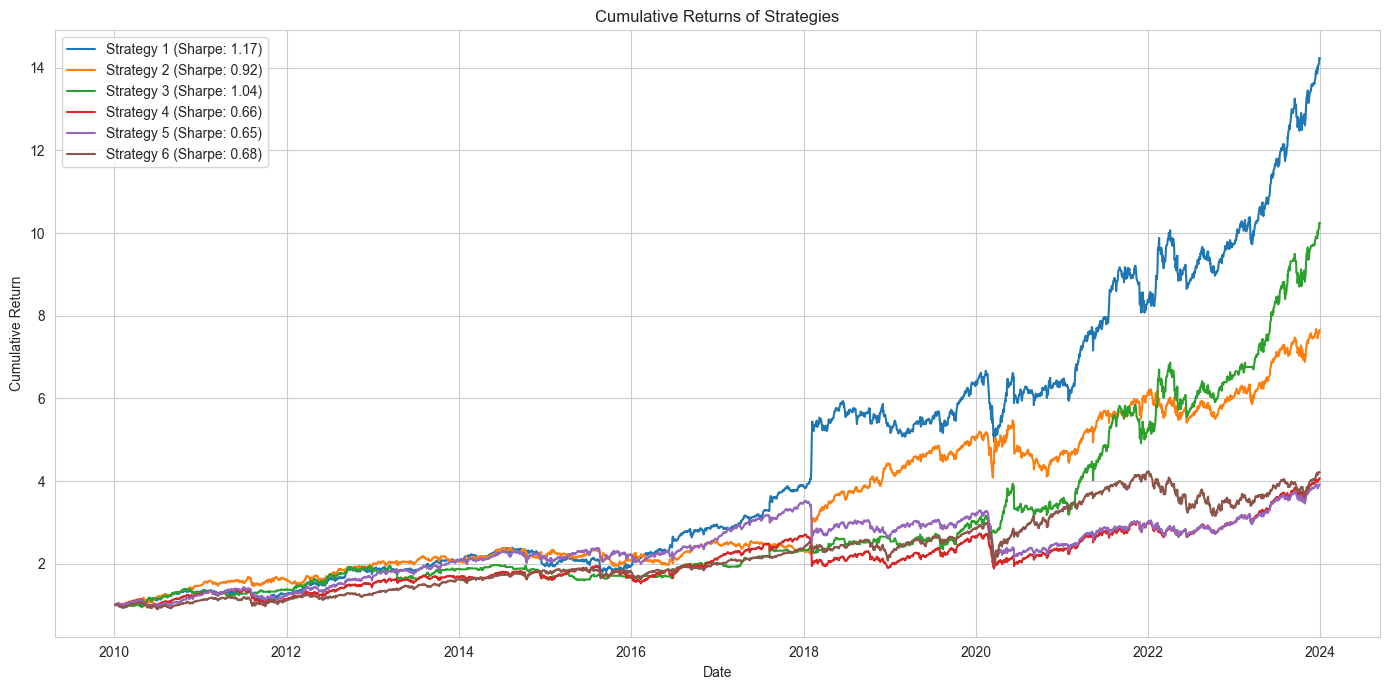

strategy1: Sharpe Ratio = 1.1717
strategy2: Sharpe Ratio = 0.9181
strategy3: Sharpe Ratio = 1.0388
strategy4: Sharpe Ratio = 0.6633
strategy5: Sharpe Ratio = 0.6493
strategy6: Sharpe Ratio = 0.6753


In [71]:
vx["signal1"] = np.where(vx["efg1"] > 0, -1, np.where(vx["efg1"] < 0, 1, 0))
vx["signal2"] = np.where(vx["efg2"] > 0, -1, np.where(vx["efg2"] < 0, 1, 0))
vx["signal3"] = np.where(vx["efg1"] > vx["efg2"], 0, vx["signal1"])
vx["signal4"] = np.where(vx["vx1close"] > vx["vx2close"], 0, vx["signal1"])
vx['1'] = 1

returns1 = []
for i in range(len(vx)):
    if i == 0:
        returns1.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx1expiry"] != vx.iloc[i]["vx1expiry"]:
            returns1.append(
                (vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1)
                * vx.iloc[i - 1]["signal1"]
            )
        else:
            returns1.append(
                (vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1)
                * vx.iloc[i - 1]["signal1"]
            )
vx["return1"] = returns1

returns2 = []
for i in range(len(vx)):
    if i == 0:
        returns2.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx2expiry"] != vx.iloc[i]["vx2expiry"]:
            returns2.append(
                (vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx3close"] - 1)
                * vx.iloc[i - 1]["signal2"]
            )
        else:
            returns2.append(
                (vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx2close"] - 1)
                * vx.iloc[i - 1]["signal2"]
            )
vx["return2"] = returns2

returns3 = []
for i in range(len(vx)):
    if i == 0:
        returns3.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx1expiry"] != vx.iloc[i]["vx1expiry"]:
            returns3.append(
                (vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1)
                * vx.iloc[i - 1]["signal3"]
            )
        else:
            returns3.append(
                (vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1)
                * vx.iloc[i - 1]["signal3"]
            )
vx["return3"] = returns3

returns4 = []
for i in range(len(vx)):
    if i == 0:
        returns4.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx1expiry"] != vx.iloc[i]["vx1expiry"]:
            returns4.append(
                -(vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1)
            )
        else:
            returns4.append(
                -(vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1)
            )
vx["return4"] = returns4

returns5 = []
for i in range(len(vx)):
    if i == 0:
        returns5.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx2expiry"] != vx.iloc[i]["vx2expiry"]:
            returns5.append(
                -(vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx3close"] - 1)
            )
        else:
            returns5.append(
                -(vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx2close"] - 1)
            )
vx["return5"] = returns5

vx["return6"] = vx["SPX_Close"].pct_change().fillna(0)



def calculate_k_columns(vx):
    result = vx.copy()

    return_signal_mapping = {
        'return1': 'signal1',
        'return2': 'signal2',
        'return3': 'signal3',
        'return4': '1',
        'return5': '1',
        'return6': '1'
    }

    for i in range(1, 7):
        result[f'k{i}'] = np.nan
        result[f'net_return{i}'] = np.nan
        result[f'cumulative_return{i}'] = np.nan

    # First pass to calculate raw k values
    for idx, date in enumerate(result.index):

        for i in range(1, 7):
            #thirty_days_ago = date - timedelta(days=30)
            #valid_lookback = result[result[return_signal_mapping[f'return{i}']] != 0]
            valid_lookback = result
            lookback_data = valid_lookback.loc[:date].copy()

            if len(lookback_data) <= 1 or (date - lookback_data.index[0]).days < 30:
                continue

            lookback_data = lookback_data.iloc[:-1]

            return_col = f'return{i}'
            signal_col = return_signal_mapping[return_col]

            if signal_col != '1':
                filtered_data = lookback_data[lookback_data[signal_col] != 0]
            else:
                filtered_data = lookback_data

            if len(filtered_data) == 0:
                continue

            abs_returns = filtered_data[return_col].abs()
            ewma = abs_returns.ewm(alpha=0.3).mean().iloc[-1]

            mean_abs_return = result[return_col].abs().mean()
            std_abs_return = result[return_col].abs().std()
            lower_bound = max(0, mean_abs_return - 2 * std_abs_return)
            upper_bound = mean_abs_return + 2 * std_abs_return
            clipped_ewma = np.clip(ewma, lower_bound, upper_bound)

            weight = 1 / clipped_ewma if clipped_ewma > 0 else 0
            result.loc[date, f'k{i}'] = weight

    # Normalize k values by dividing by their mean
    for i in range(1, 7):
        weight_col = f'k{i}'
        k_mean = result[weight_col].dropna().max()
        if k_mean > 0:  # Avoid division by zero
            result[weight_col] = result[weight_col] / k_mean

    transaction_cost_factor = 0.027

    for i in range(1, 7):
        weight_col = f'k{i}'
        return_col = f'return{i}'
        net_return_col = f'net_return{i}'

        result[f'weight_change{i}'] = result[weight_col].diff().abs().fillna(0)

        # Apply different transaction cost calculations based on return column
        if i in [1, 3, 4]:
            result[f'transaction_cost{i}'] = result[f'weight_change{i}'] * transaction_cost_factor / result['vx1close']
        elif i in [2, 5]:
            result[f'transaction_cost{i}'] = result[f'weight_change{i}'] * transaction_cost_factor / result['vx2close']
        elif i == 6:
            result[f'transaction_cost{i}'] = 0  # No transaction cost for return6

        # Ensure transaction costs are reasonable
        result[f'transaction_cost{i}'] = result[f'transaction_cost{i}'].fillna(0).clip(0, 0.1)

        # Calculate net returns with bounds
        result[net_return_col] = (result[weight_col] * result[return_col] - result[f'transaction_cost{i}']).fillna(0)

        # Clip extreme return values
        result[net_return_col] = result[net_return_col].clip(-0.5, 0.5)

        # Calculate cumulative returns
        #result[f'cumulative_return{i}'] = (1 + result[net_return_col]).cumprod()

    return result

result = calculate_k_columns(vx)
for i in range(1, 7):
    result[f'cumulative_return{i}'] = (1+result[f'net_return{i}']*(result['net_return6'].std())/(result[f'net_return{i}'].std())).cumprod()

sharpe_ratios = {}
for i in range(1, 7):
    net_return_col = f'net_return{i}'
    net_returns = result[net_return_col].dropna()
    if len(net_returns) > 0 and net_returns.std() > 0:
        sharpe_ratios[f'strategy{i}'] = net_returns.mean() / net_returns.std() * np.sqrt(252)
    else:
        sharpe_ratios[f'strategy{i}'] = 0

'''

k = 0.1  # portion of capital to invest
# Step 2: Calculate Cumulative Returns
vx["cumulative_return1"] = (1 + (vx["return6"].std()/vx["return1"].std()) * vx["return1"]).cumprod()
vx["cumulative_return2"] = (1 + (vx["return6"].std()/vx["return2"].std()) * vx["return2"]).cumprod()
vx["cumulative_return3"] = (1 + (vx["return6"].std()/vx["return3"].std()) * vx["return3"]).cumprod()
vx["cumulative_return4"] = (1 + (vx["return6"].std()/vx["return4"].std()) * vx["return4"]).cumprod()
vx["cumulative_return5"] = (1 + (vx["return6"].std()/vx["return5"].std()) * vx["return5"]).cumprod()
vx["cumulative_return6"] = (1 + vx["return6"]).cumprod()
result = vx.copy()
def calculate_sharpe(column_name):
    if column_name not in vx.columns:
        return 0.0
    daily_pct_change = vx[column_name].pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    if daily_pct_change.empty:
        return 0.0
    std_dev = daily_pct_change.std()
    if std_dev == 0 or pd.isna(std_dev):
        return 0.0
    return np.sqrt(252) * daily_pct_change.mean() / std_dev
sharpe_ratios = {}
for i in range(1,7):
    sharpe_ratios[f'strategy{i}'] = calculate_sharpe(f'cumulative_return{i}')
sharpe1_net = calculate_sharpe("cumulative_return1_net")
sharpe2_net = calculate_sharpe("cumulative_return2_net")
sharpe3_net = calculate_sharpe("cumulative_return3_net")
sharpe4_net = calculate_sharpe("cumulative_return4_net")
sharpe5_net = calculate_sharpe("cumulative_return5_net")
sharpe6_net = calculate_sharpe("cumulative_return6_net") # Use the _net version for consistency

'''

plt.figure(figsize=(14, 7))
for i in range(1, 7):
    plt.plot(result.index, result[f'cumulative_return{i}'], label=f'Strategy {i} (Sharpe: {sharpe_ratios[f"strategy{i}"]:.2f})')

plt.title('Cumulative Returns of Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for strategy, sharpe in sharpe_ratios.items():
    print(f"{strategy}: Sharpe Ratio = {sharpe:.4f}")

C:\Users\warre\AppData\Local\Temp\ipykernel_180256\746938437.py:43: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vx["return6"] = vx["SPX_Close"].pct_change().fillna(0)


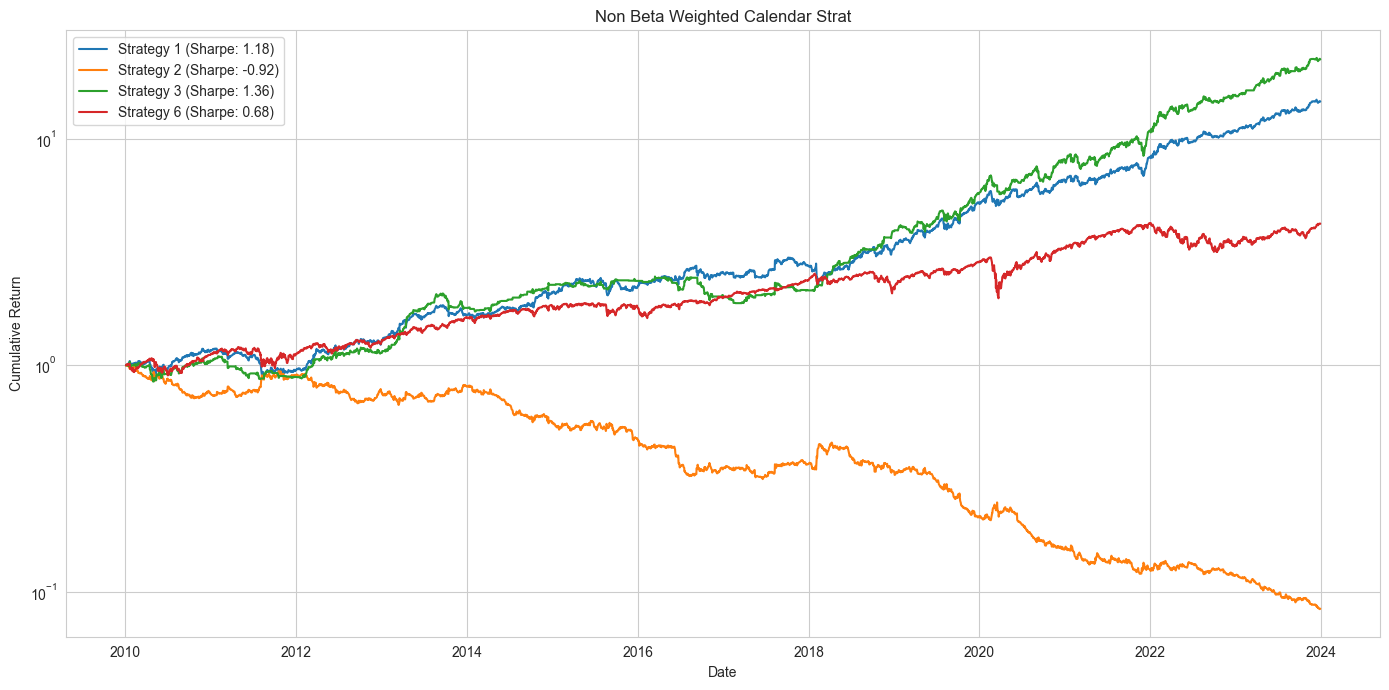

strategy1: Sharpe Ratio = 1.1832
strategy2: Sharpe Ratio = -0.9229
strategy3: Sharpe Ratio = 1.3574
strategy4: Sharpe Ratio = 0.6633
strategy5: Sharpe Ratio = 0.6493
strategy6: Sharpe Ratio = 0.6753


In [13]:
vx["signal1"] = np.where(vx["efg1"] > 0, -1, np.where(vx["efg1"] < 0, 1, 0))
vx["signal2"] = np.where(vx["efg2"] > 0, -1, np.where(vx["efg2"] < 0, 1, 0))
vx["signal3"] = np.where(vx["efg1"] > vx["efg2"], 0, vx["signal1"])
vx["signal4"] = np.where(vx["vx1close"] > vx["vx2close"], 0, vx["signal1"])
#TODO: make a beta column for the calendar strat adjustment to flat vega

vx['1'] = 1
delay = 1


returns4 = []
for i in range(len(vx)):
    if i == 0:
        returns4.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx1expiry"] != vx.iloc[i]["vx1expiry"]:
            returns4.append(
                -(vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1)
            )
        else:
            returns4.append(
                -(vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1)
            )
vx["return4"] = returns4

returns5 = []
for i in range(len(vx)):
    if i == 0:
        returns5.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx2expiry"] != vx.iloc[i]["vx2expiry"]:
            returns5.append(
                -(vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx3close"] - 1)
            )
        else:
            returns5.append(
                -(vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx2close"] - 1)
            )
vx["return5"] = returns5

vx["return6"] = vx["SPX_Close"].pct_change().fillna(0)

window = 30

# Shift so the current row is excluded
x = vx['return5'].shift(1)
y = vx['return4'].shift(1)

x_rolling = x.rolling(window=window, min_periods=1)
y_rolling = y.rolling(window=window, min_periods=1)

x_mean = x_rolling.mean()
y_mean = y_rolling.mean()

cov_xy = (x * y).rolling(window=window, min_periods=1).mean() - x_mean * y_mean
var_x = (x ** 2).rolling(window=window, min_periods=1).mean() - x_mean ** 2

vx['beta'] = cov_xy / var_x
vx['beta'].fillna(1)

returns1 = []
for i in range(len(vx)):
    if i < delay:
        returns1.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx1expiry"] != vx.iloc[i]["vx1expiry"]:
            returns1.append(
                ((vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1) - (vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx3close"] - 1))
                * vx.iloc[i - delay]["signal1"]
            )
        else:
            returns1.append(
                ((vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1) - (vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx2close"] - 1))
                * vx.iloc[i - delay]["signal1"]
            )
vx["return1"] = returns1

returns2 = []
for i in range(len(vx)):
    if i < delay:
        returns2.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx2expiry"] != vx.iloc[i]["vx2expiry"]:
            returns2.append(
                ((vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx3close"] - 1) - (vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1))
                * vx.iloc[i - delay]["signal2"]
            )
        else:
            returns2.append(
                ((vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx2close"] - 1) - (vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1))
                * vx.iloc[i - delay]["signal2"]
            )
vx["return2"] = returns2

returns3 = []
for i in range(len(vx)):
    if i < delay:
        returns3.append(0)
        continue
    else:
        if vx.iloc[i - 1]["vx1expiry"] != vx.iloc[i]["vx1expiry"]:
            returns3.append(
                ((vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx2close"] - 1) - (vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx3close"] - 1))
                * vx.iloc[i - delay]["signal3"]
            )
        else:
            returns3.append(
                ((vx.iloc[i]["vx1close"] / vx.iloc[i - 1]["vx1close"] - 1) - (vx.iloc[i]["vx2close"] / vx.iloc[i - 1]["vx2close"] - 1))
                * vx.iloc[i - delay]["signal3"]
            )
vx["return3"] = returns3


k = 0.1  # portion of capital to invest
# Step 2: Calculate Cumulative Returns
vx["cumulative_return1"] = (1 + (vx["return6"].std()/vx["return1"].std()) * vx["return1"]).cumprod()
vx["cumulative_return2"] = (1 + (vx["return6"].std()/vx["return2"].std()) * vx["return2"]).cumprod()
vx["cumulative_return3"] = (1 + (vx["return6"].std()/vx["return3"].std()) * vx["return3"]).cumprod()
vx["cumulative_return4"] = (1 + (vx["return6"].std()/vx["return4"].std()) * vx["return4"]).cumprod()
vx["cumulative_return5"] = (1 + (vx["return6"].std()/vx["return5"].std()) * vx["return5"]).cumprod()
vx["cumulative_return6"] = (1 + vx["return6"]).cumprod()
result = vx.copy()
def calculate_sharpe(column_name):
    if column_name not in vx.columns:
        return 0.0
    daily_pct_change = vx[column_name].pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    if daily_pct_change.empty:
        return 0.0
    std_dev = daily_pct_change.std()
    if std_dev == 0 or pd.isna(std_dev):
        return 0.0
    return np.sqrt(252) * daily_pct_change.mean() / std_dev
sharpe_ratios = {}
for i in range(1,7):
    sharpe_ratios[f'strategy{i}'] = calculate_sharpe(f'cumulative_return{i}')
sharpe1_net = calculate_sharpe("cumulative_return1")
sharpe2_net = calculate_sharpe("cumulative_return2")
sharpe3_net = calculate_sharpe("cumulative_return3")
sharpe4_net = calculate_sharpe("cumulative_return4")
sharpe5_net = calculate_sharpe("cumulative_return5")
sharpe6_net = calculate_sharpe("cumulative_return6") # Use the _net version for consistency



plt.figure(figsize=(14, 7))
for i in [1,2,3,6]:
    plt.plot(result.index, result[f'cumulative_return{i}'], label=f'Strategy {i} (Sharpe: {sharpe_ratios[f"strategy{i}"]:.2f})')

plt.title('Non Beta Weighted Calendar Strat')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

for strategy, sharpe in sharpe_ratios.items():
    print(f"{strategy}: Sharpe Ratio = {sharpe:.4f}")

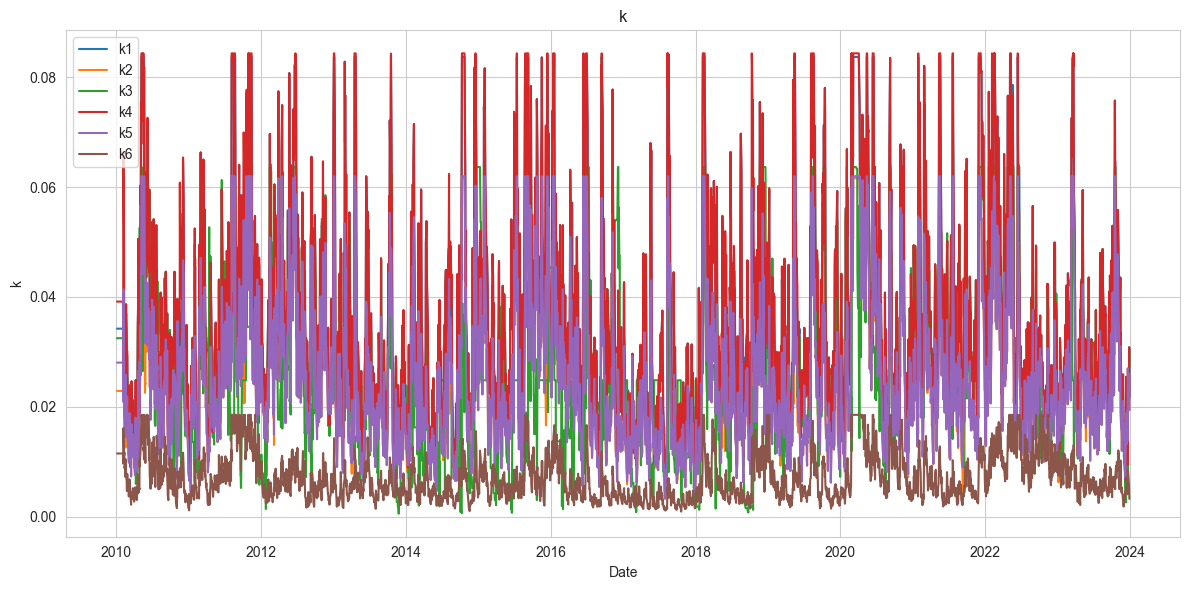

In [51]:
plt.figure(figsize=(12, 6))

for i in range(1, 7):
    col = f"k{i}"
    plt.plot(vx.index, vx[col], label=f"k{i}")

plt.title("k")
plt.xlabel("Date")
plt.ylabel("k")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

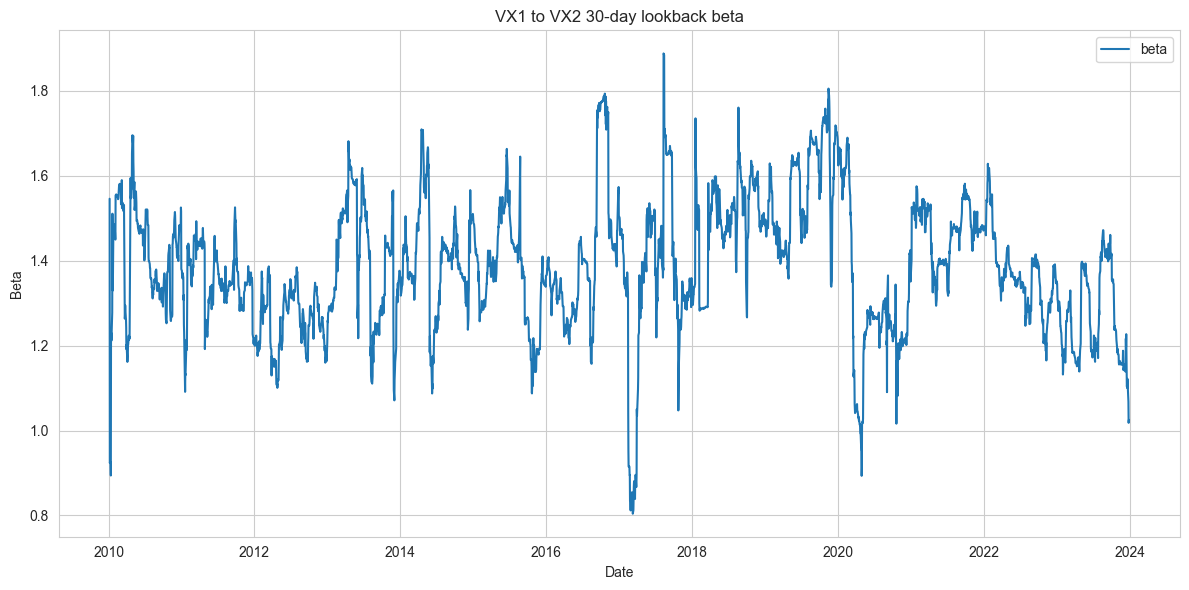

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(vx.index, vx['beta'], label="beta")

plt.title("VX1 to VX2 30-day lookback beta")
plt.xlabel("Date")
plt.ylabel('Beta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

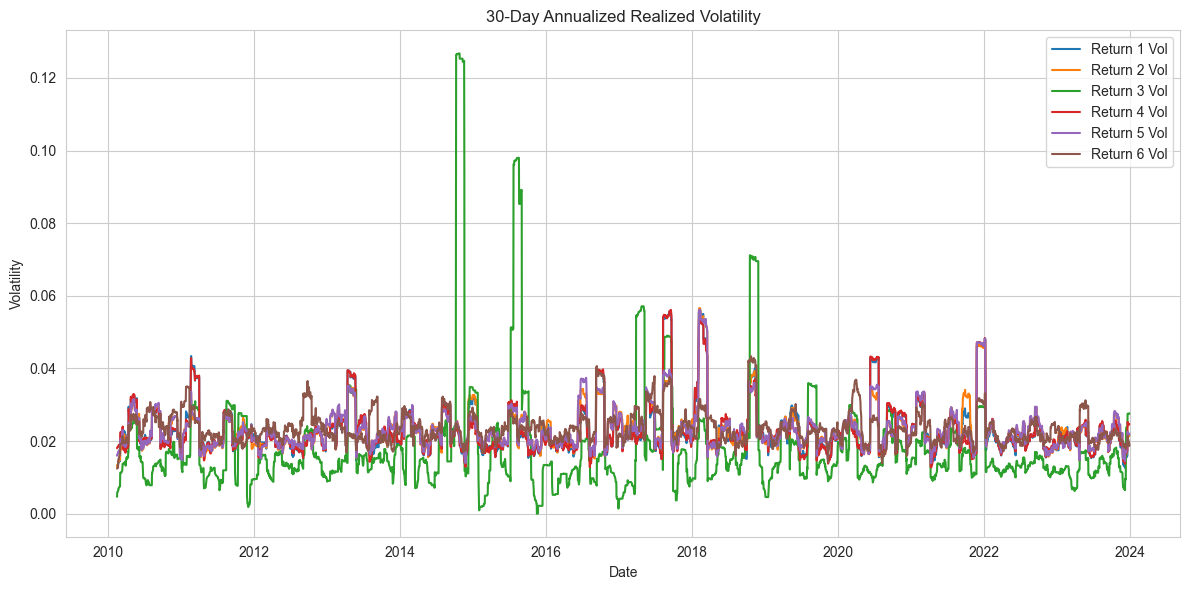

In [55]:
plt.figure(figsize=(12, 6))

for i in range(1, 7):
    col = f"cumulative_return{i}"
    daily_returns = result[col].pct_change()
    realized_vol = daily_returns.rolling(30).std() * np.sqrt(252)
    plt.plot(result.index, realized_vol, label=f"Return {i} Vol")

plt.title("30-Day Annualized Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
flip1 = (vx["signal1"] != vx["signal1"].shift(1)) * 1
flip2 = (vx["signal2"] != vx["signal2"].shift(1)) * 1
flip3 = (vx["signal3"] != vx["signal3"].shift(1)) * 1
flip4 = (vx["signal4"] != vx["signal4"].shift(1)) * 1

print(
    len(flip1) / flip1.sum(),
    len(flip2) / flip2.sum(),
    len(flip3) / flip3.sum(),
    len(flip4) / flip4.sum(),
)

4.214114832535885 5.25037257824143 3.084938704028021 4.1012805587892895


In [61]:
print(
    vx["k1"].min(),
    vx["k2"].min(),
    vx["k3"].min(),
    vx["k4"].min(),
    vx["k5"].min(),
    vx["k6"].min(),
)
vx = vx.drop(
    columns=[
        "k1",
        "k2",
        "k3",
        "k4",
        "k5",
        "k6",
        "return1",
        "return2",
        "return3",
        "return4",
        "return5",
        "return6",
        "cumulative_return1",
        "cumulative_return2",
        "cumulative_return3",
        "cumulative_return4",
        "cumulative_return5",
        "cumulative_return6",
    ]
)

0.0029076449888265545 0.002265261181682808 0.0018975332068309986 0.005296275374072036 0.004442700189608623 0.000938225387604701


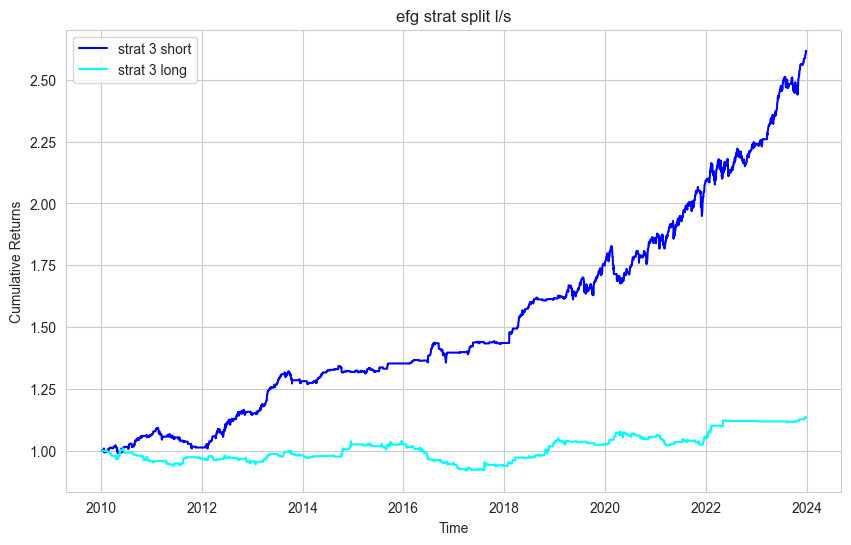

In [67]:
splits1 = vx["return3"].where(vx["signal3"].shift(1) == -1, 0)
splitl1 = vx["return3"].where(vx["signal3"].shift(1) == 1, 0)
# splits2 = vx["return4"].where(vx["signal4"].shift(1) == -1, 0)
# splitl2 = vx["return4"].where(vx["signal4"].shift(1) == 1, 0)

k = 0.1
crets1 = (1 + k * splits1).cumprod()
cretl1 = (1 + k * splitl1).cumprod()
# crets2 = (1 + k * splits2).cumprod()
# cretl2 = (1 + k * splitl2).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(vx.index, crets1, label="strat 3 short", color="blue")
# plt.plot(vx.index, crets2, label="strat 4 short", color="orange")
plt.plot(vx.index, cretl1, label="strat 3 long", color="cyan")
# plt.plot(vx.index, cretl2, label="strat 4 long", color="brown")
plt.title("efg strat split l/s")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

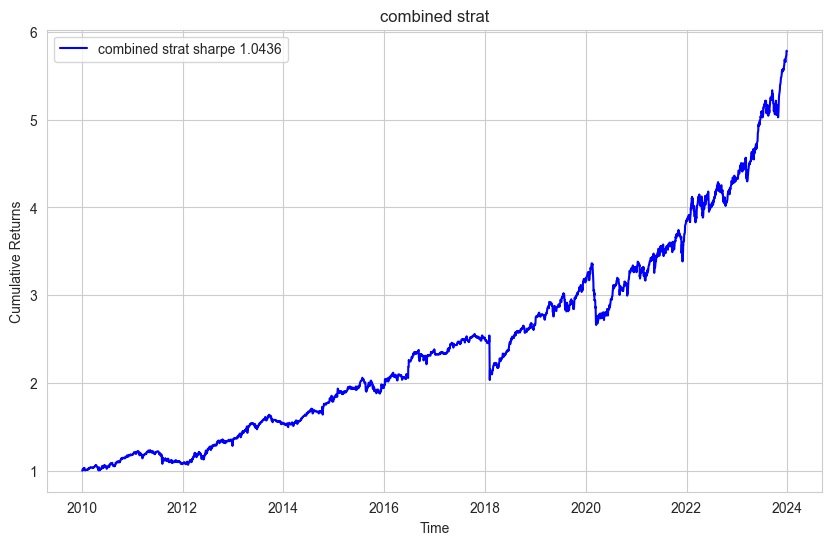

In [98]:
returns = vx["return1"] + vx["return2"]
cret = (1 + k * returns).cumprod()
sharpe = np.sqrt(252) * returns.mean() / returns.std()

plt.figure(figsize=(10, 6))
plt.plot(vx.index, cret, label=f"combined strat sharpe {sharpe:.4f}", color="blue")
plt.title("combined strat")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

return1    0.386915
return2    0.254564
return3    0.269491
return4    0.734740
return5    0.728086
dtype: float64


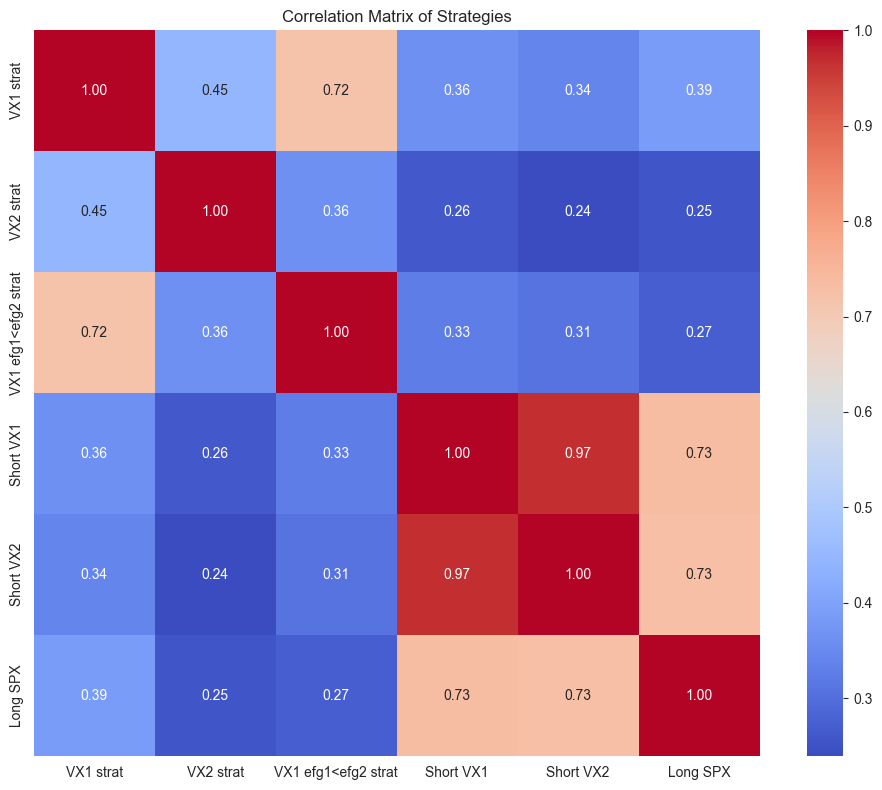

In [72]:
print(
    vx[["return1", "return2", "return3", "return4", "return5"]].corrwith(vx["return6"])
)

# Rename columns for plot display
rename_dict = {
    "return1": "VX1 strat",
    "return2": "VX2 strat",
    "return3": "VX1 efg1<efg2 strat",
    "return4": "Short VX1",
    "return5": "Short VX2",
    "return6": "Long SPX",
}

# Select and rename the return columns
returns = vx[["return1", "return2", "return3", "return4", "return5", "return6"]].rename(
    columns=rename_dict
)

# Compute and plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Strategies")
plt.tight_layout()
plt.show()

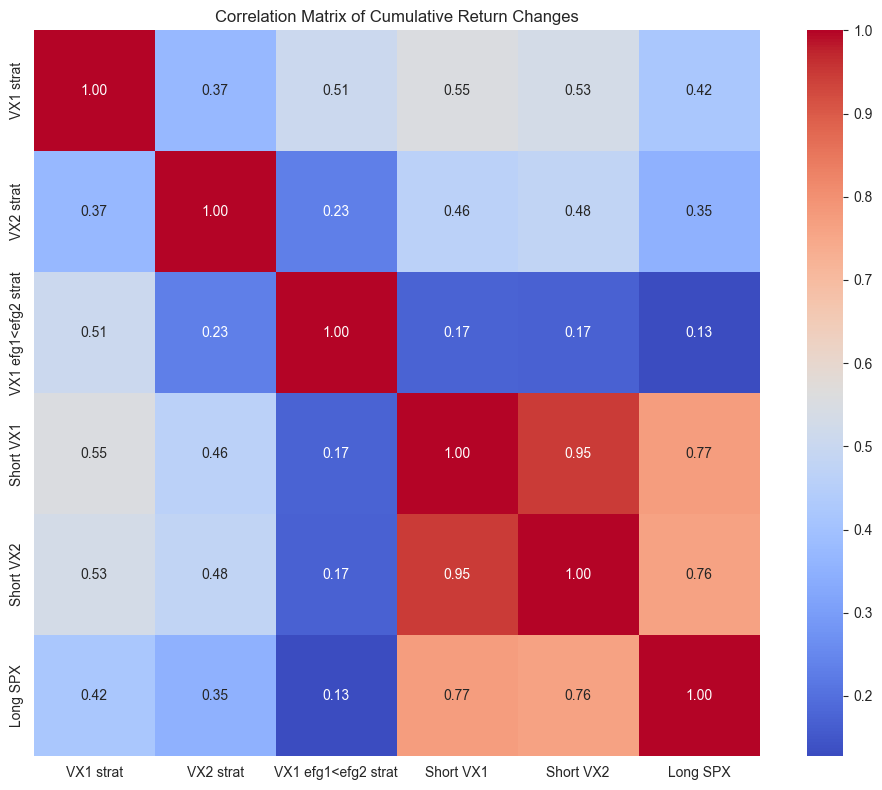

In [48]:
# Create a new DataFrame of percent changes for cumulative returns
cumulative_returns_pct_change = pd.concat(
    [
        result["cumulative_return1"].pct_change(),
        result["cumulative_return2"].pct_change(),
        result["cumulative_return3"].pct_change(),
        result["cumulative_return4"].pct_change(),
        result["cumulative_return5"].pct_change(),
        result["cumulative_return6"].pct_change(),
    ],
    axis=1,
)

# Rename columns for display
cumulative_returns_pct_change.columns = [
    "VX1 strat",
    "VX2 strat",
    "VX1 efg1<efg2 strat",
    "Short VX1",
    "Short VX2",
    "Long SPX",
]

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cumulative_returns_pct_change.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
)
plt.title("Correlation Matrix of Cumulative Return Changes")
plt.tight_layout()
plt.show()

In [57]:
for i in range(1,4):
    print((result[f'signal{i}']==1).sum()/len(result[f'signal{i}']), (result[f'signal{i}']==-1).sum()/len(result[f'signal{i}']), (result[f'signal{i}']==0).sum()/len(result[f'signal{i}']))

0.22395685495316492 0.7519159806982685 0.024127164348566564
0.24127164348566563 0.7346011921657678 0.024127164348566564
0.1592392847005393 0.44876525688333807 0.3919954584161226


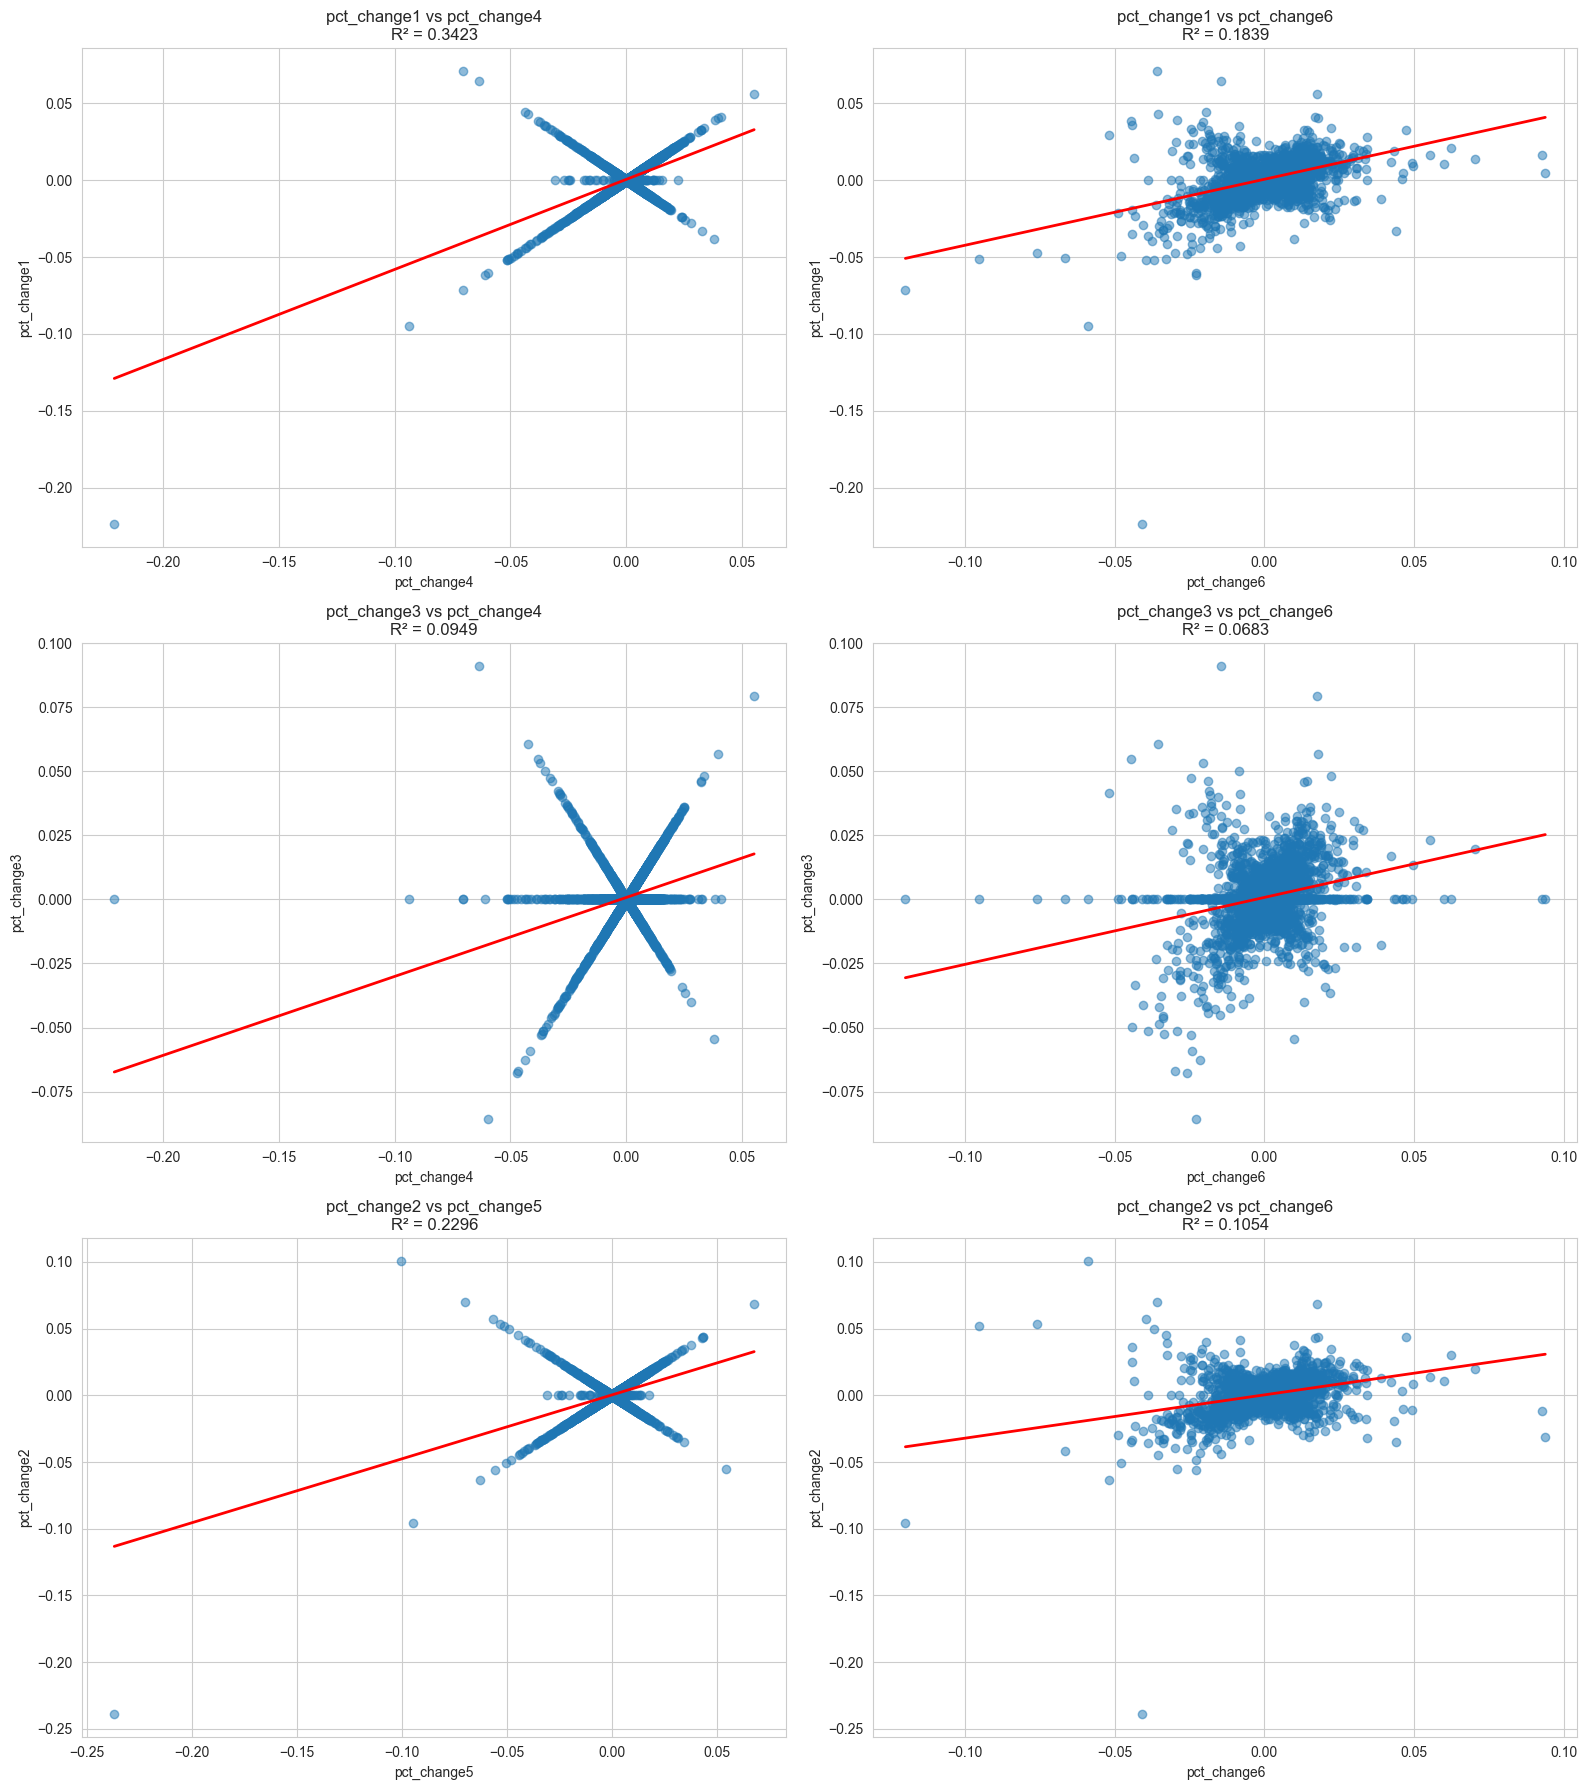

1. Regression: pct_change1 against pct_change4
Equation: pct_change1 = 0.0004 + 0.5851 * pct_change4
T-statistics:
Intercept: t = 2.8475, p = 0.0044
pct_change4: t = 42.8036, p = 0.0000
R-squared: 0.3423


2. Regression: pct_change1 against pct_change6
Equation: pct_change1 = 0.0005 + 0.4288 * pct_change6
T-statistics:
Intercept: t = 2.9633, p = 0.0031
pct_change6: t = 28.1613, p = 0.0000
R-squared: 0.1839


3. Regression: pct_change3 against pct_change4
Equation: pct_change3 = 0.0007 + 0.3081 * pct_change4
T-statistics:
Intercept: t = 4.2306, p = 0.0000
pct_change4: t = 19.2151, p = 0.0000
R-squared: 0.0949


4. Regression: pct_change3 against pct_change6
Equation: pct_change3 = 0.0008 + 0.2614 * pct_change6
T-statistics:
Intercept: t = 4.2774, p = 0.0000
pct_change6: t = 16.0672, p = 0.0000
R-squared: 0.0683


5. Regression: pct_change2 against pct_change5
Equation: pct_change2 = 0.0003 + 0.4792 * pct_change5
T-statistics:
Intercept: t = 1.6978, p = 0.0896
pct_change5: t = 32.3909, p

In [67]:
def run_pct_change_regression_analysis_with_plots(result):
    # Create a new dataframe for percentage changes
    pct_change_df = pd.DataFrame(index=result.index)

    # Calculate percentage changes for all cumulative return series
    for i in range(1, 7):
        pct_change_df[f'pct_change{i}'] = result[f'cumulative_return{i}'].pct_change().fillna(0)

    # Set up figure for plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()

    # Regression 1: pct_change1 against pct_change4
    X1a = pct_change_df[['pct_change4']].iloc[1:].dropna()
    y1a = pct_change_df['pct_change1'].loc[X1a.index]
    X1a_sm = sm.add_constant(X1a)
    model1a = sm.OLS(y1a, X1a_sm).fit()

    # Regression 2: pct_change1 against pct_change6
    X1b = pct_change_df[['pct_change6']].iloc[1:].dropna()
    y1b = pct_change_df['pct_change1'].loc[X1b.index]
    X1b_sm = sm.add_constant(X1b)
    model1b = sm.OLS(y1b, X1b_sm).fit()

    # Regression 3: pct_change3 against pct_change4
    X2a = pct_change_df[['pct_change4']].iloc[1:].dropna()
    y2a = pct_change_df['pct_change3'].loc[X2a.index]
    X2a_sm = sm.add_constant(X2a)
    model2a = sm.OLS(y2a, X2a_sm).fit()

    # Regression 4: pct_change3 against pct_change6
    X2b = pct_change_df[['pct_change6']].iloc[1:].dropna()
    y2b = pct_change_df['pct_change3'].loc[X2b.index]
    X2b_sm = sm.add_constant(X2b)
    model2b = sm.OLS(y2b, X2b_sm).fit()

    # Regression 5: pct_change2 against pct_change5
    X3a = pct_change_df[['pct_change5']].iloc[1:].dropna()
    y3a = pct_change_df['pct_change2'].loc[X3a.index]
    X3a_sm = sm.add_constant(X3a)
    model3a = sm.OLS(y3a, X3a_sm).fit()

    # Regression 6: pct_change2 against pct_change6
    X3b = pct_change_df[['pct_change6']].iloc[1:].dropna()
    y3b = pct_change_df['pct_change2'].loc[X3b.index]
    X3b_sm = sm.add_constant(X3b)
    model3b = sm.OLS(y3b, X3b_sm).fit()

    # Plot 1: pct_change1 vs pct_change4
    axes[0].scatter(X1a['pct_change4'], y1a, alpha=0.5)
    # Generate points for the regression line
    x_range = np.linspace(X1a['pct_change4'].min(), X1a['pct_change4'].max(), 100)
    y_pred = model1a.params['const'] + model1a.params['pct_change4'] * x_range
    axes[0].plot(x_range, y_pred, 'r', linewidth=2)
    axes[0].set_title(f"pct_change1 vs pct_change4\nR² = {model1a.rsquared:.4f}")
    axes[0].set_xlabel('pct_change4')
    axes[0].set_ylabel('pct_change1')
    axes[0].grid(True)

    # Plot 2: pct_change1 vs pct_change6
    axes[1].scatter(X1b['pct_change6'], y1b, alpha=0.5)
    x_range = np.linspace(X1b['pct_change6'].min(), X1b['pct_change6'].max(), 100)
    y_pred = model1b.params['const'] + model1b.params['pct_change6'] * x_range
    axes[1].plot(x_range, y_pred, 'r', linewidth=2)
    axes[1].set_title(f"pct_change1 vs pct_change6\nR² = {model1b.rsquared:.4f}")
    axes[1].set_xlabel('pct_change6')
    axes[1].set_ylabel('pct_change1')
    axes[1].grid(True)

    # Plot 3: pct_change3 vs pct_change4
    axes[2].scatter(X2a['pct_change4'], y2a, alpha=0.5)
    x_range = np.linspace(X2a['pct_change4'].min(), X2a['pct_change4'].max(), 100)
    y_pred = model2a.params['const'] + model2a.params['pct_change4'] * x_range
    axes[2].plot(x_range, y_pred, 'r', linewidth=2)
    axes[2].set_title(f"pct_change3 vs pct_change4\nR² = {model2a.rsquared:.4f}")
    axes[2].set_xlabel('pct_change4')
    axes[2].set_ylabel('pct_change3')
    axes[2].grid(True)

    # Plot 4: pct_change3 vs pct_change6
    axes[3].scatter(X2b['pct_change6'], y2b, alpha=0.5)
    x_range = np.linspace(X2b['pct_change6'].min(), X2b['pct_change6'].max(), 100)
    y_pred = model2b.params['const'] + model2b.params['pct_change6'] * x_range
    axes[3].plot(x_range, y_pred, 'r', linewidth=2)
    axes[3].set_title(f"pct_change3 vs pct_change6\nR² = {model2b.rsquared:.4f}")
    axes[3].set_xlabel('pct_change6')
    axes[3].set_ylabel('pct_change3')
    axes[3].grid(True)

    # Plot 5: pct_change2 vs pct_change5
    axes[4].scatter(X3a['pct_change5'], y3a, alpha=0.5)
    x_range = np.linspace(X3a['pct_change5'].min(), X3a['pct_change5'].max(), 100)
    y_pred = model3a.params['const'] + model3a.params['pct_change5'] * x_range
    axes[4].plot(x_range, y_pred, 'r', linewidth=2)
    axes[4].set_title(f"pct_change2 vs pct_change5\nR² = {model3a.rsquared:.4f}")
    axes[4].set_xlabel('pct_change5')
    axes[4].set_ylabel('pct_change2')
    axes[4].grid(True)

    # Plot 6: pct_change2 vs pct_change6
    axes[5].scatter(X3b['pct_change6'], y3b, alpha=0.5)
    x_range = np.linspace(X3b['pct_change6'].min(), X3b['pct_change6'].max(), 100)
    y_pred = model3b.params['const'] + model3b.params['pct_change6'] * x_range
    axes[5].plot(x_range, y_pred, 'r', linewidth=2)
    axes[5].set_title(f"pct_change2 vs pct_change6\nR² = {model3b.rsquared:.4f}")
    axes[5].set_xlabel('pct_change6')
    axes[5].set_ylabel('pct_change2')
    axes[5].grid(True)

    plt.tight_layout()
    plt.show()

    # Print regression equations and statistics
    print("1. Regression: pct_change1 against pct_change4")
    print(f"Equation: pct_change1 = {model1a.params['const']:.4f} + {model1a.params['pct_change4']:.4f} * pct_change4")
    print("T-statistics:")
    print(f"Intercept: t = {model1a.tvalues['const']:.4f}, p = {model1a.pvalues['const']:.4f}")
    print(f"pct_change4: t = {model1a.tvalues['pct_change4']:.4f}, p = {model1a.pvalues['pct_change4']:.4f}")
    print(f"R-squared: {model1a.rsquared:.4f}")
    print("\n")

    print("2. Regression: pct_change1 against pct_change6")
    print(f"Equation: pct_change1 = {model1b.params['const']:.4f} + {model1b.params['pct_change6']:.4f} * pct_change6")
    print("T-statistics:")
    print(f"Intercept: t = {model1b.tvalues['const']:.4f}, p = {model1b.pvalues['const']:.4f}")
    print(f"pct_change6: t = {model1b.tvalues['pct_change6']:.4f}, p = {model1b.pvalues['pct_change6']:.4f}")
    print(f"R-squared: {model1b.rsquared:.4f}")
    print("\n")

    print("3. Regression: pct_change3 against pct_change4")
    print(f"Equation: pct_change3 = {model2a.params['const']:.4f} + {model2a.params['pct_change4']:.4f} * pct_change4")
    print("T-statistics:")
    print(f"Intercept: t = {model2a.tvalues['const']:.4f}, p = {model2a.pvalues['const']:.4f}")
    print(f"pct_change4: t = {model2a.tvalues['pct_change4']:.4f}, p = {model2a.pvalues['pct_change4']:.4f}")
    print(f"R-squared: {model2a.rsquared:.4f}")
    print("\n")

    print("4. Regression: pct_change3 against pct_change6")
    print(f"Equation: pct_change3 = {model2b.params['const']:.4f} + {model2b.params['pct_change6']:.4f} * pct_change6")
    print("T-statistics:")
    print(f"Intercept: t = {model2b.tvalues['const']:.4f}, p = {model2b.pvalues['const']:.4f}")
    print(f"pct_change6: t = {model2b.tvalues['pct_change6']:.4f}, p = {model2b.pvalues['pct_change6']:.4f}")
    print(f"R-squared: {model2b.rsquared:.4f}")
    print("\n")

    print("5. Regression: pct_change2 against pct_change5")
    print(f"Equation: pct_change2 = {model3a.params['const']:.4f} + {model3a.params['pct_change5']:.4f} * pct_change5")
    print("T-statistics:")
    print(f"Intercept: t = {model3a.tvalues['const']:.4f}, p = {model3a.pvalues['const']:.4f}")
    print(f"pct_change5: t = {model3a.tvalues['pct_change5']:.4f}, p = {model3a.pvalues['pct_change5']:.4f}")
    print(f"R-squared: {model3a.rsquared:.4f}")
    print("\n")

    print("6. Regression: pct_change2 against pct_change6")
    print(f"Equation: pct_change2 = {model3b.params['const']:.4f} + {model3b.params['pct_change6']:.4f} * pct_change6")
    print("T-statistics:")
    print(f"Intercept: t = {model3b.tvalues['const']:.4f}, p = {model3b.pvalues['const']:.4f}")
    print(f"pct_change6: t = {model3b.tvalues['pct_change6']:.4f}, p = {model3b.pvalues['pct_change6']:.4f}")
    print(f"R-squared: {model3b.rsquared:.4f}")

    return model1a, model1b, model2a, model2b, model3a, model3b, pct_change_df

model1a, model1b, model2a, model2b, model3a, model3b, pct_change_df = run_pct_change_regression_analysis_with_plots(result)
